# Intercomparison

**Author:** Hannah Kerner

**Last updated:** October 24, 2023

**Description:** Runs intercomparison for Rwanda 2019

## 1. Setup

In [9]:
import ee
# import geemap
import sys
import pandas as pd
import geopandas as gpd

# ee.Initialize()

# sys.path.append("../..")

from src.compare_covermaps import TARGETS, filter_by_bounds, generate_report, CLASS_COL, COUNTRY_COL
from src.compare_covermaps import TEST_COUNTRIES, TEST_CODE

## 2. Read in evaluation set

In [11]:
country = "Uganda"
country_code = TEST_CODE[country]
dataset_path = TEST_COUNTRIES[country] #"../" + TEST_COUNTRIES[country]

In [12]:
dataset_path = '/content/crop-mask/data/datasets/Uganda_NorthCEO2022.csv'

In [13]:
df = pd.read_csv(dataset_path)[["lat", "lon", "class_probability", "subset"]]
df = df[(df["class_probability"] != 0.5)].copy()
# use only test data because validation points used for harvest-dev map
df = df[df["subset"] == "testing"].copy()
df[CLASS_COL] = (df["class_probability"] > 0.5).astype(int)
df[COUNTRY_COL] = country

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="epsg:4326")
gdf = filter_by_bounds(country_code=country_code, gdf=gdf)

## 3. Run intercomparison

In [14]:
TARGETS = {k:v for k,v in TARGETS.items()}

In [15]:
for cropmap in TARGETS.values():
    if country not in cropmap.countries:
        continue
    print(f"[{country}] sampling " + cropmap.title + "...")
    map_sampled = cropmap.extract_test(gdf).copy()
    gdf = pd.merge(gdf, map_sampled, on=["lat", "lon"], how="left")
    gdf.drop_duplicates(subset =['geometry'],inplace=True)  # TODO find why points get duplicated, subset=['geometry'] to remove duplicate

[Uganda] sampling copernicus...
[Uganda] sampling worldcover-v100...
[Uganda] sampling worldcover-v200...
[Uganda] sampling worldcereal-v100...
[Uganda] sampling glad...
[Uganda] sampling asap...
[Uganda] sampling dynamicworld...
[Uganda] sampling gfsad-gcep...
[Uganda] sampling gfsad-lgrip...
[Uganda] sampling digital-earth-africa...
[Uganda] sampling esa-cci-africa...
[Uganda] sampling globcover-v23...
[Uganda] sampling globcover-v22...
[Uganda] sampling esri-lulc...
[Uganda] sampling nabil-etal-2021...
[Uganda] sampling harvest-dev...


In [17]:
comparisons = []
for cropmap in TARGETS.keys():
    if cropmap not in gdf.columns:
        continue
    temp = gdf[[CLASS_COL, cropmap]].dropna()
    comparison = generate_report(cropmap, country, temp[CLASS_COL], temp[cropmap])
    comparisons.append(comparison)

results = pd.concat(comparisons).set_index(["dataset"])

# Add ensemble
ensemble_maps = ["glad", "worldcover-v200", "esri-lulc"] # Should be odd number
print(f"Ensemble maps: {ensemble_maps}")
ensemble = gdf[ensemble_maps].mode(axis='columns')
comparison = generate_report("ensemble-subset", country, gdf[CLASS_COL], ensemble)
comparisons.append(comparison)

results = pd.concat(comparisons).set_index(["dataset"])
results

/content/crop-mask/src/area_utils.py:473: RuntimeWarning: invalid value encountered in divide
  sigma = ((n_j_px**2) * (cm_div) * (cm_div_comp) / (n_j_su - 1)).sum(axis=1)
/content/crop-mask/src/area_utils.py:475: RuntimeWarning: invalid value encountered in divide
  expr_1 = (n_j_px**2) * ((1 - p_i) ** 2) * u_j * (1 - u_j) / (n_j_su - 1)
/content/crop-mask/src/area_utils.py:408: RuntimeWarning: invalid value encountered in divide
  return u_j * (1 - u_j) / (n_dotj - 1)
/content/crop-mask/src/area_utils.py:511: RuntimeWarning: invalid value encountered in divide
  sigma = (w_j**2) * (u_j) * (1 - u_j) / (cm.sum(axis=0) - 1)


Ensemble maps: ['glad', 'worldcover-v200', 'esri-lulc']


,country,crop_f1,std_crop_f1,accuracy,std_acc,crop_recall_pa,std_crop_pa,noncrop_recall_pa,std_noncrop_pa,crop_precision_ua,std_crop_ua,noncrop_precision_ua,std_noncrop_ua,crop_support,noncrop_support,tn,fp,fn,tp
dataset,,,,,,,,,,,,,,,,,,,
copernicus,Uganda,0.55,0.18,0.76,0.03,0.61,0.06,0.80,0.02,0.51,0.06,0.86,0.03,56,169,136,33,22,34
worldcover-v100,Uganda,0.28,0.16,0.77,0.03,0.18,0.03,0.97,0.01,0.67,0.13,0.78,0.03,56,169,164,5,46,10
worldcover-v200,Uganda,0.26,0.15,0.77,0.03,0.16,0.03,0.98,0.01,0.69,0.13,0.78,0.03,56,169,165,4,47,9
worldcereal-v100,Uganda,0.41,0.19,0.75,0.03,0.36,0.05,0.88,0.02,0.49,0.08,0.80,0.03,56,169,148,21,36,20
glad,Uganda,0.54,0.18,0.75,0.03,0.59,0.06,0.80,0.02,0.50,0.06,0.86,0.03,56,169,136,33,23,33
asap,Uganda,0.47,0.18,0.72,0.03,0.50,0.06,0.79,0.02,0.44,0.06,0.83,0.03,56,169,133,36,28,28
dynamicworld,Uganda,0.04,NaN,0.76,NaN,0.02,NaN,1.00,NaN,1.00,NaN,0.75,0.03,56,169,169,0,55,1
gfsad-gcep,Uganda,0.56,0.17,0.75,0.03,0.64,0.06,0.78,0.02,0.49,0.06,0.87,0.03,56,169,132,37,20,36
gfsad-lgrip,Uganda,0.57,0.17,0.75,0.03,0.66,0.05,0.78,0.02,0.50,0.06,0.87,0.03,56,169,132,37,19,37


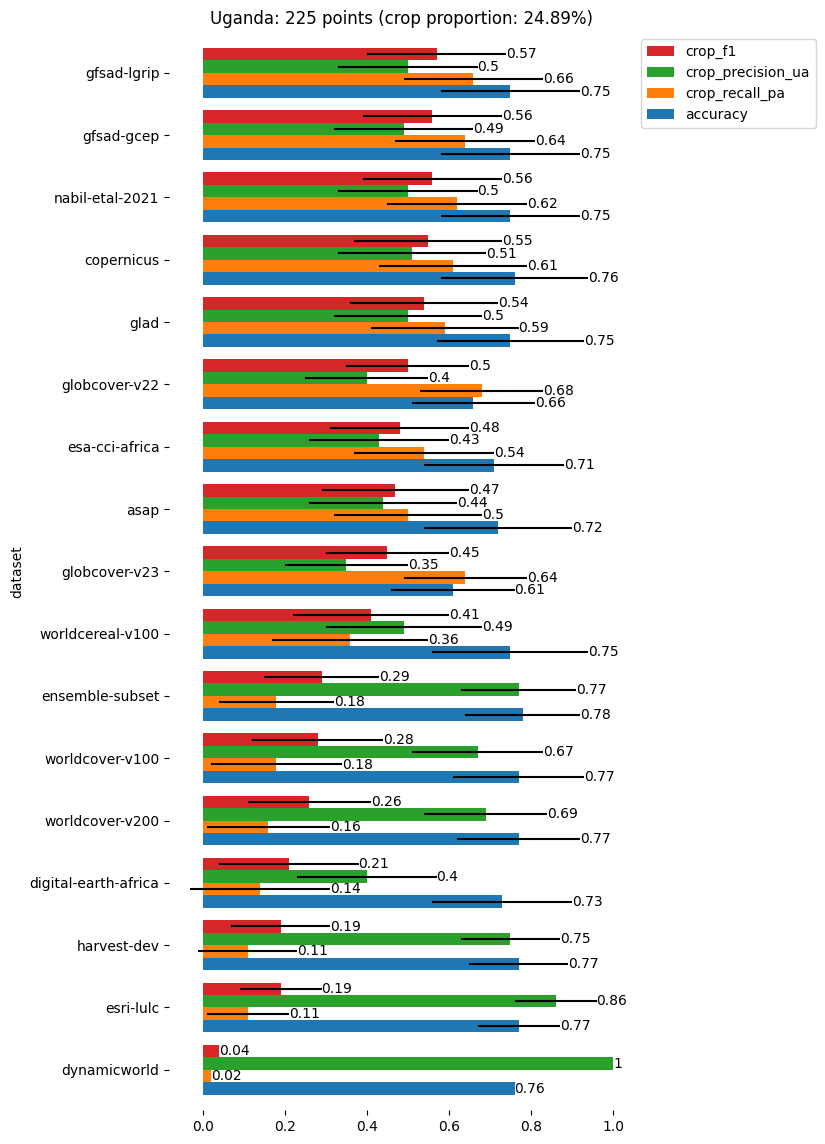

In [18]:
crop_proportion = round(gdf[CLASS_COL].value_counts(normalize=True)[1], 4) * 100
ax = results.sort_values("crop_f1").plot(
    y=["accuracy", "crop_recall_pa", "crop_precision_ua", "crop_f1"],
    xerr="std_crop_f1",
    kind="barh",
    figsize=(6, 14),
    width=0.8,
    title=f"{country}: {len(gdf)} points (crop proportion: {crop_proportion}%)",
);

for c in ax.containers[1::2]:
    ax.bar_label(c)

for border in ["top", "right", "bottom", "left"]:
    ax.spines[border].set_visible(False)

ax.legend(bbox_to_anchor=(1, 1), reverse=True);

## 4. Visualize best available map

In [ ]:
# Run this cell to view and export map
print("To view and export map copy and paste the text below the dashed line into GEE\n" + "-"*100)
best_dataset = results["crop_f1"].idxmax()
if best_dataset in TARGETS:
    print(TARGETS[best_dataset].ee_script(country))
else:
    image_var_names = [TARGETS[d].title_safe for d in ensemble_maps]
    for i, dataset in enumerate(ensemble_maps):
        print(TARGETS[dataset].ee_script(country, include_prefix=(i == 0), include_export=False))
        print("\n")
    print(f"var ensemble = ee.ImageCollection.fromImages([{', '.join(image_var_names)}]).mode()")
    print(f"Map.addLayer(ensemble, classVis, 'Cropland from ensemble');")
    print(f"""
Export.image.toCloudStorage({{
    image: ensemble,
    description: "{country}_ensemble_{'_'.join(image_var_names)}",
    bucket: 'crop-mask-preds-merged',
    fileNamePrefix: "{country}_ensemble_{'_'.join(image_var_names)}",
    region: aoi,
    scale: 10,
    crs: "EPSG:4326",
    maxPixels: 1e10,
    skipEmptyTiles: true
}});""")